<a href="https://colab.research.google.com/github/kanajash/CUDA_SCHARR/blob/main/Milestone_2__Integrating_PRoject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**C - SCHARR**

In [ ]:
%%writefile scharr_filter.c

#include <stddef.h>
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <time.h>

#define NUM_EXEC 30

#define WIDTH 256
#define HEIGHT 256

// Scharr operator kernels
int scharr_x[3][3] = {
  {3, 0, -3},
  {10, 0, -10},
  {3, 0, -3}
};

int scharr_y[3][3] = {
  {3, 10, 3},
  {0, 0, 0},
  {-3, -10, -3}
};

void apply_scharr_filter(unsigned char *image, unsigned char *output, int width, int height) {

  for (int y = 1; y < height - 1; y++) {
    for (int x = 1; x < width - 1; x++) {
      int gx = 0, gy = 0;
      for (int i = -1; i <= 1; i++) {
        for (int j = -1; j <= 1; j++) {
          int pixel = image[(y + i) * width + (x + j)];
          gx += pixel * scharr_x[i + 1][j + 1];
          gy += pixel * scharr_y[i + 1][j + 1];
        }
      }
      int magnitude = abs(gx) + abs(gy);
      if (magnitude > 255) magnitude = 255;
      output[y * width + x] = (unsigned char)magnitude;
    }
  }



}

int main() {
  const char input_file[] = "input.pgm";
  const char output_file[] = "c_output.pgm";
  FILE *file = fopen(input_file, "rb");
  int width, height, maxval;
  double elapsed_time = 0;
  char header[3];

  if (!file) {
    printf("Could not open file: %s\n", input_file);
    return 1;
  }

  // Read PGM header
  if (fscanf(file, "%2s\n", header) != 1 || header[0] != 'P' || header[1] != '5') {
    printf("Invalid PGM file format: Not a P5 file.\n");
    fclose(file);
    return 1;
  }

  // Skip any comment lines
  // int c = getc(file);
  // while (c == '#') {
  //     while (getc(file) != '\n');
  //     c = getc(file);
  // }
  // ungetc(c, file);

  // Read image dimensions and max value
  if (fscanf(file, "%d %d\n%d\n", &width, &height, &maxval) != 3) {
    printf("Invalid PGM header format.\n");
    fclose(file);
    return 1;
  }

  // Allocate memory for image and output
  unsigned char *image = (unsigned char *)malloc(width * height);
  unsigned char *output = (unsigned char *)malloc(width * height);

  if (!image || !output) {
    printf("Memory allocation failed.\n");
    if (image) free(image);
    if (output) free(output);
    fclose(file);
    return 1;
  }

  if (fread(image, 1, width * height, file) != width * height) {
    printf("Error reading image data.\n");
    free(image);
    free(output);
    fclose(file);
    return 1;
  }

  fclose(file);

  // Apply Scharr filter
  apply_scharr_filter(image, output, width, height);

  for (size_t i = 0; i < NUM_EXEC; ++i) {

    clock_t start = clock();
    apply_scharr_filter(image, output, width, height);
    clock_t end = clock();
    elapsed_time += (double)(end - start) * 1E6 / CLOCKS_PER_SEC;
  }

  // Write output image
  file = fopen(output_file, "wb");
  if (!file) {
    printf("Could not open output file: %s\n", output_file);
    free(image);
    free(output);
    return 1;
  }

  fprintf(file, "P5\n%d %d\n%d\n", width, height, maxval);
  fwrite(output, 1, width * height, file);
  fclose(file);

  printf("Processing time: %.3f microseconds\n", elapsed_time/NUM_EXEC);

  free(image);
  free(output);
  return 0;
}

Overwriting scharr_filter.c


In [ ]:
%%shell
gcc -Wall -pedantic -o scharr_filter scharr_filter.c -lm

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving Comp_10.png to Comp_10.png


In [ ]:
%%shell
if !(dpkg -s imagemagick) > /dev/null; then
  echo "Installing imagemagick"
  apt-get install imagemagick
fi
convert "Comp_10.png" -colorspace Gray input.pgm

In [ ]:
#apt-get install imagemagick
#convert "FLOWER - COMPLEX.jpg" -colorspace Gray input.pgm

In [ ]:
!./scharr_filter

Processing time: 8180.467 microseconds


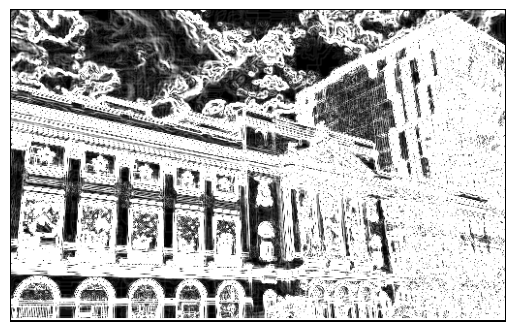

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the output PGM image
image = Image.open("c_output.pgm")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()


# **CUDA_SCHARR (Parallel Computing)**

In [ ]:
%%writefile Scharr_CUDA.cu

#include <stdio.h>
#include <opencv2/opencv.hpp>

#define TILE_WIDTH 32

// CUDA Kernel
__global__ void Scharr_CUDA (unsigned char* in, unsigned char *out, int width, int height)
{
  // compute indexes
  int index_x = blockIdx.x * blockDim.x + threadIdx.x;
  int index_y = blockIdx.y * blockDim.y + threadIdx.y;

  int index = index_y * width + index_x;

  // scharr_x = [
  //    +3 0  -3
  //   +10 0 -10
  //    +3 0  -3
  // ]

  // scharr_y = [
  //   +3 +10 +3
  //    0   0  0
  //   -3 -10 -3
  // ]

  // apply scharr filter
  if (index_x > 1 && index_y >= 1 && index_x < (width -1) && index_y < (height - 1))
  {
    int sum_x = (3 * in[(index_y - 1) * width + (index_x - 1)]) + (-3 * in[(index_y - 1) * width + (index_x + 1)])
      + (10 * in[(index_y) * width + (index_x - 1)]) + (-10 * in[(index_y) * width + (index_x + 1)])
      + (3 * in[(index_y + 1) * width + (index_x - 1)]) + (-3 * in[(index_y + 1) * width + (index_x + 1)]);

    int sum_y = (3 * in[(index_y - 1) * width + (index_x - 1)]) + (10 * in[(index_y - 1) * width + (index_x)]) + (3 * in[(index_y - 1) * width + (index_x + 1)])
      + (-3 * in[(index_y + 1) * width + (index_x - 1)]) + (-10 * in[(index_y + 1) * width + (index_x)]) + (-3 * in[(index_y + 1) * width + (index_x + 1)]);

    int mag = abs(sum_x) + abs(sum_y);
    mag = mag > 255 ? 255 : mag < 0 ? 0 : mag;


    out[index] = mag;
  }

}

int main()
{
  cv::Mat in_image = cv::imread("Comp_10.png", cv::IMREAD_GRAYSCALE); // change for image input

  if (in_image.empty())
  {
    printf("ERROR: No Image. \n");
    return -1;
  }

  // image width, image height, and size of image
  int width = in_image.cols;
  int height = in_image.rows;
  size_t ARRAY_BYTES = width * height * sizeof(unsigned char);

  // number of iterations
  const size_t NUM_EXEC = 30;

  // declare array
  unsigned char *in, *out;
  cudaMallocManaged(&in, ARRAY_BYTES);
  cudaMallocManaged(&out, ARRAY_BYTES);

  // get GPU ID
  int device = -1;
  cudaGetDevice(&device);

  // memory advise
  cudaMemAdvise(in, ARRAY_BYTES, cudaMemAdviseSetPreferredLocation, cudaCpuDeviceId);
  cudaMemAdvise(in, ARRAY_BYTES, cudaMemAdviseSetReadMostly, cudaCpuDeviceId);

  // "prefetch data" to create CPU page memory
  cudaMemPrefetchAsync (in, ARRAY_BYTES, cudaCpuDeviceId, NULL);

  // "prefetch data" to create GPU page memory
  cudaMemPrefetchAsync(out, ARRAY_BYTES, device, NULL);

  // initialize input
  memcpy(in, in_image.data, ARRAY_BYTES);

  // "prefetch data" from CPU-GPU
  cudaMemPrefetchAsync(in, ARRAY_BYTES, device, NULL);

  // setup CUDA kernel
  size_t threadDimBlockx = TILE_WIDTH;
  size_t threadDimBlocky = TILE_WIDTH;

  dim3 blockShape = dim3(threadDimBlockx, threadDimBlocky);
  dim3 gridShape ( (width + threadDimBlockx - 1) / threadDimBlockx , (height + threadDimBlocky - 1) / threadDimBlocky );

  // launch kernel
  printf("*** function = Scharr Edge Detection \n");
  for (size_t i = 0; i < NUM_EXEC; i++)
    Scharr_CUDA <<< gridShape, blockShape >>> (in, out, width, height);

  // barrier
  cudaDeviceSynchronize();

  // "prefetch data" from GPU-CPU
  cudaMemPrefetchAsync (out, ARRAY_BYTES, cudaCpuDeviceId, NULL);

  // create output image
  // not supported in google colab version
  // cv::Mat outImage(height, width, CV_8UC1, out);

  cv::Mat outImage(height, width, CV_8UC1);
  memcpy(outImage.data, out, ARRAY_BYTES);

  // save image
  cv::imwrite("outImage.jpg", outImage);

  // free memory
  cudaFree(in);
  cudaFree(out);

  return 0;
}




Overwriting Scharr_CUDA.cu


In [ ]:
%%shell
apt-get update
apt-get install libopencv-dev


Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
%%shell
pkg-config --cflags opencv4
pkg-config --libs opencv4


-I/usr/include/opencv4 
-lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core 


In [ ]:
%%shell
nvcc Scharr_CUDA.cu -o Scharr_CUDA -arch=sm_75 \
`pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
%%shell
nvprof ./Scharr_CUDA

==62632== NVPROF is profiling process 62632, command: ./Scharr_CUDA
*** function = Scharr Edge Detection 
==62632== Profiling application: ./Scharr_CUDA
==62632== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  526.00us        30  17.533us  12.768us  153.40us  Scharr_CUDA(unsigned char*, unsigned char*, int, int)
      API calls:   98.80%  128.11ms         2  64.056ms  24.172us  128.09ms  cudaMallocManaged
                    0.28%  366.76us         4  91.690us  60.949us  110.52us  cudaMemPrefetchAsync
                    0.27%  345.55us         1  345.55us  345.55us  345.55us  cudaDeviceSynchronize
                    0.25%  325.00us        30  10.833us  3.3510us  139.59us  cudaLaunchKernel
                    0.18%  233.38us       114  2.0470us     186ns  89.963us  cuDeviceGetAttribute
                    0.16%  208.37us         2  104.19us  51.899us  156.48us  cudaFree
                    0.04%  45.858us 

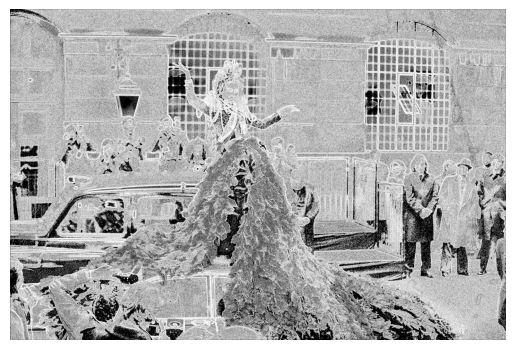

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the output PGM image
image = Image.open("outImage.jpg")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()


##SCHARR - SHARED MEMORY##

In [ ]:
%%writefile Scharr_SM.cu

#include <stdio.h>
#include <opencv2/opencv.hpp>

#define TILE_WIDTH 32  // Define TILE_WIDTH instead of BLOCK_SIZE

// CUDA Kernel
__global__ void Scharr_SM (unsigned char* in, unsigned char *out, int width, int height)
{
    // Shared memory declaration
    extern __shared__ unsigned char sharedMem[];

    // Global index
    int inX = blockIdx.x * blockDim.x + threadIdx.x;
    int inY = blockIdx.y * blockDim.y + threadIdx.y;
    int gIndex = inY * width + inX;

    // Local thread index with halo space
    int localX = threadIdx.x + 1;
    int localY = threadIdx.y + 1;
    int sWidth = blockDim.x + 2;

    // Shared memory index
    int sIndex = localY * sWidth + localX;

    // Load data into shared memory
    if (inX < width && inY < height) {
        sharedMem[sIndex] = in[gIndex];
    } else {
        sharedMem[sIndex] = 0;
    }

    __syncthreads();

    // Fill halo space
    if (threadIdx.x == 0 && inX > 0)
        sharedMem[sIndex - 1] = in[gIndex - 1];

    if (threadIdx.x == blockDim.x - 1 && inX < width - 1)
        sharedMem[sIndex + 1] = in[gIndex + 1];

    if (threadIdx.y == 0 && inY > 0)
        sharedMem[sIndex - sWidth] = in[gIndex - width];

    if (threadIdx.y == blockDim.y - 1 && inY < height - 1)
        sharedMem[sIndex + sWidth] = in[gIndex + width];

    __syncthreads();

    // Apply Scharr filter
    if (inX > 0 && inY > 0 && inX < (width - 1) && inY < (height - 1) && gIndex < width * height)
    {
        int sX =  (-3 * sharedMem[sIndex - sWidth - 1]) + (3 * sharedMem[sIndex - sWidth + 1])
                  + (-10 * sharedMem[sIndex - 1]) + (10 * sharedMem[sIndex + 1])
                  + (-3 * sharedMem[sIndex + sWidth - 1]) + (3 * sharedMem[sIndex + sWidth + 1]);

        int sY =  (3 * sharedMem[sIndex - sWidth - 1]) + (10 * sharedMem[sIndex - sWidth]) + (3 * sharedMem[sIndex - sWidth + 1])
                  + (-3 * sharedMem[sIndex + sWidth - 1]) + (-10 * sharedMem[sIndex + sWidth]) + (-3 * sharedMem[sIndex + sWidth + 1]);

        int mag = abs(sX) + abs(sY);
        mag = mag > 255 ? 255 : mag;

        out[gIndex] = (unsigned char) mag;
    }
}

int main()
{
    cv::Mat in_image = cv::imread("Simple_1.png", cv::IMREAD_GRAYSCALE);

    if (in_image.empty())
    {
        printf("ERROR: No Image. \n");
        return -1;
    }

    // Image width, height, and size
    int width = in_image.cols;
    int height = in_image.rows;
    size_t size = width * height * sizeof(unsigned char);

    const size_t iterations = 2;

    // Memory allocation
    unsigned char *in, *out;
    cudaMallocManaged(&in, size);
    cudaMallocManaged(&out, size);

    // Get GPU ID
    int device = -1;
    cudaGetDevice(&device);

    // memory advise
    cudaMemAdvise(in, size, cudaMemAdviseSetPreferredLocation, cudaCpuDeviceId);
    cudaMemAdvise(in, size, cudaMemAdviseSetReadMostly, cudaCpuDeviceId);

    // "prefetch data" to create CPU page memory
    cudaMemPrefetchAsync (in, size, cudaCpuDeviceId, NULL);

    // "prefetch data" to create GPU page memory
    cudaMemPrefetchAsync (out, size, device, NULL);

    // initialize input
    memcpy(in, in_image.data, size);

    // "prefetch data" from CPU-GPU
    cudaMemPrefetchAsync(in, size, device, NULL);

    // Setup CUDA kernel
    size_t threadDimBlockx = TILE_WIDTH;
    size_t threadDimBlocky = TILE_WIDTH;

    dim3 blockShape = dim3(threadDimBlockx, threadDimBlocky);
    dim3 gridShape ((width + threadDimBlockx - 1) / threadDimBlockx, (height + threadDimBlocky - 1) / threadDimBlocky);

    // Launch kernel
    printf("*** function = Scharr Edge Detection \n");
    for (size_t i = 0; i < iterations; i++)
        Scharr_SM <<< gridShape, blockShape, (threadDimBlockx + 2) * (threadDimBlocky + 2) * sizeof(unsigned char) >>> (in, out, width, height);

    // Synchronize device
    cudaDeviceSynchronize();

    // Prefetch data from GPU-CPU
    cudaMemPrefetchAsync(out, size, cudaCpuDeviceId, NULL);

    // Create output image
    cv::Mat outImage(height, width, CV_8UC1);
    memcpy(outImage.data, out, size);

    // Save image
    cv::imwrite("outImage.jpg", outImage);

    // Free memory
    cudaFree(in);
    cudaFree(out);

    return 0;
}


Writing Scharr_SM.cu


In [ ]:
%%shell
apt-get update
apt-get install libopencv-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
0% [Working]

CalledProcessError: Command 'apt-get update
apt-get install libopencv-dev
' died with <Signals.SIGINT: 2>.

In [ ]:
%%shell
pkg-config --cflags opencv4
pkg-config --libs opencv4

-I/usr/include/opencv4 
-lopencv_stitching -lopencv_alphamat -lopencv_aruco -lopencv_barcode -lopencv_bgsegm -lopencv_bioinspired -lopencv_ccalib -lopencv_dnn_objdetect -lopencv_dnn_superres -lopencv_dpm -lopencv_face -lopencv_freetype -lopencv_fuzzy -lopencv_hdf -lopencv_hfs -lopencv_img_hash -lopencv_intensity_transform -lopencv_line_descriptor -lopencv_mcc -lopencv_quality -lopencv_rapid -lopencv_reg -lopencv_rgbd -lopencv_saliency -lopencv_shape -lopencv_stereo -lopencv_structured_light -lopencv_phase_unwrapping -lopencv_superres -lopencv_optflow -lopencv_surface_matching -lopencv_tracking -lopencv_highgui -lopencv_datasets -lopencv_text -lopencv_plot -lopencv_ml -lopencv_videostab -lopencv_videoio -lopencv_viz -lopencv_wechat_qrcode -lopencv_ximgproc -lopencv_video -lopencv_xobjdetect -lopencv_objdetect -lopencv_calib3d -lopencv_imgcodecs -lopencv_features2d -lopencv_dnn -lopencv_flann -lopencv_xphoto -lopencv_photo -lopencv_imgproc -lopencv_core 


In [ ]:
%%shell
nvcc Scharr_SM.cu -o Scharr_SM -arch=sm_75 \
`pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
%%shell
nvprof ./Scharr_SM

ERROR: No Image. 
======== Error: Application returned non-zero code 255


CalledProcessError: Command 'nvprof ./Scharr_SM
' returned non-zero exit status 9.

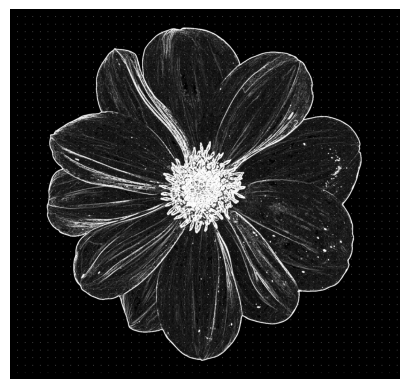

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the output PGM image
image = Image.open("outImage.jpg")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()

##CUDA - SHARED MEM##

In [ ]:
%%writefile Scharr_SM1.cu

#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <math.h>

#define TILE_WIDTH 32

__global__ void Scharr_SM(unsigned char* in, unsigned char* out, int width, int height)
{
    extern __shared__ unsigned char sharedMem[];

    int sWidth = TILE_WIDTH + 2;
    int localX = threadIdx.x + 1;
    int localY = threadIdx.y + 1;
    int inX = blockIdx.x * blockDim.x + threadIdx.x;
    int inY = blockIdx.y * blockDim.y + threadIdx.y;
    int sIndex = localY * sWidth + localX;

    // Clamp global indices
    int clampedX = min(max(inX, 0), width - 1);
    int clampedY = min(max(inY, 0), height - 1);

    // Load the central tile and halo in a coalesced pattern
    for (int dy = -1; dy <= 1; ++dy) {
        for (int dx = -1; dx <= 1; ++dx) {
            int lx = threadIdx.x + 1 + dx;
            int ly = threadIdx.y + 1 + dy;
            int gx = min(max(inX + dx, 0), width - 1);
            int gy = min(max(inY + dy, 0), height - 1);
            sharedMem[ly * sWidth + lx] = in[gy * width + gx];
        }
    }

    __syncthreads();

    if (inX > 0 && inY > 0 && inX < width - 1 && inY < height - 1) {
        int sX = (-3 * sharedMem[sIndex - sWidth - 1]) + (3 * sharedMem[sIndex - sWidth + 1])
               + (-10 * sharedMem[sIndex - 1]) + (10 * sharedMem[sIndex + 1])
               + (-3 * sharedMem[sIndex + sWidth - 1]) + (3 * sharedMem[sIndex + sWidth + 1]);

        int sY = (3 * sharedMem[sIndex - sWidth - 1]) + (10 * sharedMem[sIndex - sWidth]) + (3 * sharedMem[sIndex - sWidth + 1])
               + (-3 * sharedMem[sIndex + sWidth - 1]) + (-10 * sharedMem[sIndex + sWidth]) + (-3 * sharedMem[sIndex + sWidth + 1]);

        int mag = abs(sX) + abs(sY);
        mag = min(mag, 255);

        // Optional noise suppression
        if (mag < 80) {
            mag = 0;
        } else {
            int avg = (sharedMem[sIndex - 1] + sharedMem[sIndex + 1] +
                       sharedMem[sIndex - sWidth] + sharedMem[sIndex + sWidth]) / 4;
            if (mag < avg) mag = 0;
        }

        out[inY * width + inX] = (unsigned char)mag;
    }
}

int main()
{
    cv::Mat in_image = cv::imread("Comp_1.png", cv::IMREAD_GRAYSCALE); // input
    if (in_image.empty()) {
        printf("ERROR: No Image.\n");
        return -1;
    }

    int width = in_image.cols;
    int height = in_image.rows;
    size_t size = width * height * sizeof(unsigned char);

    unsigned char *in, *out;
    cudaMallocManaged(&in, size);
    cudaMallocManaged(&out, size);
    memcpy(in, in_image.data, size);

    dim3 blockShape(TILE_WIDTH, TILE_WIDTH);
    dim3 gridShape((width + TILE_WIDTH - 1) / TILE_WIDTH, (height + TILE_WIDTH - 1) / TILE_WIDTH);
    size_t sharedSize = (TILE_WIDTH + 2) * (TILE_WIDTH + 2) * sizeof(unsigned char);

    Scharr_SM<<<gridShape, blockShape, sharedSize>>>(in, out, width, height);
    cudaDeviceSynchronize();

    cv::Mat outImage(height, width, CV_8UC1);
    memcpy(outImage.data, out, size);
    cv::imwrite("outImage.jpg", outImage);

    cudaFree(in);
    cudaFree(out);
    return 0;
}


Overwriting Scharr_SM1.cu


In [ ]:
%%shell
apt-get update
apt-get install libopencv-dev

Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
%%shell
nvcc Scharr_SM1.cu -o Scharr_SM1 -arch=sm_75 \
`pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
%%shell
nvprof ./Scharr_SM1

==62531== NVPROF is profiling process 62531, command: ./Scharr_SM1
==62531== Profiling application: ./Scharr_SM1
==62531== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:  100.00%  1.0179ms         1  1.0179ms  1.0179ms  1.0179ms  Scharr_SM(unsigned char*, unsigned char*, int, int)
      API calls:   98.66%  122.14ms         2  61.070ms  20.652us  122.12ms  cudaMallocManaged
                    0.84%  1.0450ms         1  1.0450ms  1.0450ms  1.0450ms  cudaDeviceSynchronize
                    0.18%  218.45us       114  1.9160us     159ns  81.289us  cuDeviceGetAttribute
                    0.17%  212.69us         2  106.35us  52.161us  160.53us  cudaFree
                    0.12%  142.59us         1  142.59us  142.59us  142.59us  cudaLaunchKernel
                    0.01%  13.736us         1  13.736us  13.736us  13.736us  cuDeviceGetName
                    0.01%  13.583us         3  4.5270us     205ns  12.263us  cuDevi

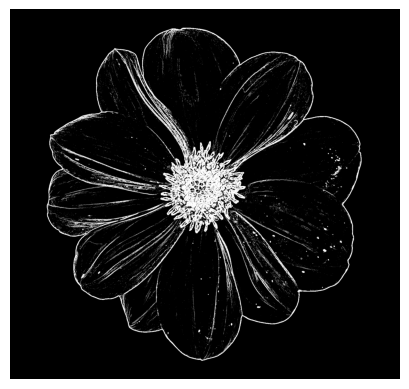

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the output PGM image
image = Image.open("outImage.jpg")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()

## Cuda Shared Mem v2

In [ ]:
%%writefile scharr_smv2.cu
#include <stdio.h>
#include <opencv2/opencv.hpp>

#define TILE_SIZE 32
#define KERNEL_DIM 3

// CUDA Kernel
__global__ void Scharr_CUDA(unsigned char* in, unsigned char *out, int width, int height, int* kernelx, int* kernely, size_t kernelDim) {
  // Calculate global indices
  int col = blockIdx.x * (TILE_SIZE - kernelDim + 1) + threadIdx.x;
  int row = blockIdx.y * (TILE_SIZE - kernelDim + 1) + threadIdx.y;

  // Load data into shared memory
  __shared__ unsigned char shm[TILE_SIZE][TILE_SIZE];

  // https://www.songho.ca/dsp/convolution/convolution2d_example.html
  // https://github.com/krunal1313/2d-Convolution-CUDA/blob/master/convolution.cu
  if (row >= 0 && row < height && col >= 0 && col < width) {
    shm[threadIdx.y][threadIdx.x] = in[row * width + col];
  } else {
    shm[threadIdx.y][threadIdx.x] = 0;
  }

  __syncthreads();

  if (threadIdx.y < (TILE_SIZE - kernelDim + 1) && threadIdx.x < (TILE_SIZE - kernelDim + 1) &&
      row < height - kernelDim + 1 && col < width - kernelDim + 1) {

    int tmpx = 0, tmpy = 0;

    // Apply Scharr kernels
    for (int i = 0; i < kernelDim; i++) {
      for (int j = 0; j < kernelDim; j++) {
        tmpx += shm[threadIdx.y + i][threadIdx.x + j] * kernelx[j * kernelDim + i];
        tmpy += shm[threadIdx.y + i][threadIdx.x + j] * kernely[j * kernelDim + i];
      }
    }

    int mag = abs(tmpx) + abs(tmpy);
    mag = mag > 255 ? 255 : mag < 0 ? 0 : mag;

    out[row * width + col] = mag;
  }
}

int main() {

  const size_t NUM_EXEC = 30;

  // Scharr kernels
  int kernelx[KERNEL_DIM * KERNEL_DIM] = {
    3,  0, -3,
    10,  0, -10,
    3,  0, -3
  };

  int kernely[KERNEL_DIM * KERNEL_DIM] = {
    3, 10,  3,
    0,  0,  0,
    -3, -10, -3
  };

  // Read input image
  cv::Mat in_image = cv::imread("Comp_10.png", cv::IMREAD_GRAYSCALE); //change
  if (in_image.empty()) {
    printf("ERROR: No Image. \n");
    return -1;
  }

  int width = in_image.cols;
  int height = in_image.rows;
  size_t ARRAY_BYTES = width * height * sizeof(unsigned char);
  size_t kernelSize = KERNEL_DIM * KERNEL_DIM * sizeof(int);

  // Allocate device memory
  unsigned char *in, *out;
  cudaMallocManaged(&in, ARRAY_BYTES);
  cudaMallocManaged(&out, ARRAY_BYTES);

  // Get GPU ID
  int device = -1;
  cudaGetDevice(&device);

  // Memory advice
  cudaMemAdvise(in, ARRAY_BYTES, cudaMemAdviseSetPreferredLocation, cudaCpuDeviceId);
  cudaMemAdvise(in, ARRAY_BYTES, cudaMemAdviseSetReadMostly, device);

  // Prefetch data to CPU
  cudaMemPrefetchAsync(in, ARRAY_BYTES, cudaCpuDeviceId, NULL);

  // Prefetch output to GPU
  cudaMemPrefetchAsync(out, ARRAY_BYTES, device, NULL);

  // Copy input image data
  memcpy(in, in_image.data, ARRAY_BYTES);

  // Prefetch input to GPU
  cudaMemPrefetchAsync(in, ARRAY_BYTES, device, NULL);

  // Allocate kernel matrices on device
  int *kernel_x, *kernel_y;
  cudaMalloc(&kernel_x, kernelSize);
  cudaMalloc(&kernel_y, kernelSize);
  cudaMemcpy(kernel_x, kernelx, kernelSize, cudaMemcpyHostToDevice);
  cudaMemcpy(kernel_y, kernely, kernelSize, cudaMemcpyHostToDevice);

  // Setup CUDA kernel dimensions
  size_t kernelDim = 3;
  dim3 blockShape(TILE_SIZE, TILE_SIZE);

  // Calculate grid dimensions based on tile size
  // https://github.com/krunal1313/2d-Convolution-CUDA/blob/master/convolution.cu
	dim3 gridShape((width - KERNEL_DIM - 1) / (TILE_SIZE - KERNEL_DIM + 1), (height - KERNEL_DIM - 1) / (TILE_SIZE - KERNEL_DIM + 1));

  printf("*** function = Scharr Edge Detection \n");
  for (size_t i = 0; i < NUM_EXEC; i++) {
    Scharr_CUDA<<<gridShape, blockShape>>>(in, out, width, height, kernel_x, kernel_y, kernelDim);
  }

  cudaDeviceSynchronize();

  // Prefetch output to CPU
  cudaMemPrefetchAsync(out, ARRAY_BYTES, cudaCpuDeviceId, NULL);

  // Create output image
  cv::Mat outImage(height, width, CV_8UC1);
  memcpy(outImage.data, out, ARRAY_BYTES);

  // Save image
  cv::imwrite("outImage_sharedv2.jpg", outImage);

  // Free memory
  cudaFree(in);
  cudaFree(out);
  cudaFree(kernel_x);
  cudaFree(kernel_y);

  return 0;
}

Overwriting scharr_smv2.cu


In [ ]:
%%shell
nvcc scharr_smv2.cu -o scharr_smv2 -arch=sm_75 \
`pkg-config --cflags --libs opencv4`

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
%%shell
nvprof ./scharr_smv2

==63842== NVPROF is profiling process 63842, command: ./scharr_smv2
*** function = Scharr Edge Detection 
==63842== Profiling application: ./scharr_smv2
==63842== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   99.80%  962.44us        30  32.081us  26.591us  188.76us  Scharr_CUDA(unsigned char*, unsigned char*, int, int, int*, int*, unsigned long)
                    0.20%  1.8880us         2     944ns     672ns  1.2160us  [CUDA memcpy HtoD]
      API calls:   98.16%  121.02ms         2  60.508ms  17.485us  121.00ms  cudaMallocManaged
                    0.67%  823.55us         1  823.55us  823.55us  823.55us  cudaDeviceSynchronize
                    0.30%  370.59us         4  92.647us  58.628us  111.48us  cudaMemPrefetchAsync
                    0.26%  314.85us         4  78.712us  9.9220us  147.11us  cudaFree
                    0.25%  308.65us        30  10.288us  3.3210us  141.29us  cudaLaunchKernel
           

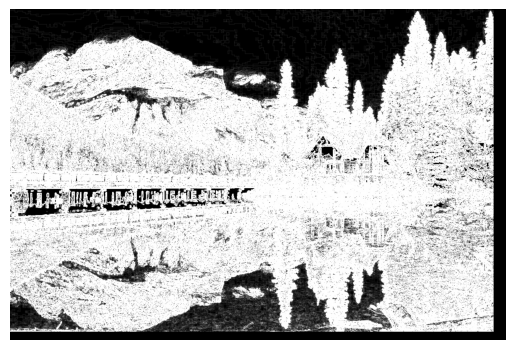

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the output PGM image
image = Image.open("outImage_sharedv2.jpg")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()

##Cuda Texture Memory##

In [ ]:
%%writefile Scharr_Texture.cu
#include <stdio.h>
#include <opencv2/opencv.hpp>
#include <cuda_runtime.h>

#define NUM_EXEC 30

__global__ void Scharr_Texture_Fast(cudaTextureObject_t texObj, unsigned char* out, int width, int height)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;

    if (x <= 0 || y <= 0 || x >= width - 1 || y >= height - 1)
        return;

    unsigned char p1 = tex2D<unsigned char>(texObj, x - 1, y - 1);
    unsigned char p2 = tex2D<unsigned char>(texObj, x,     y - 1);
    unsigned char p3 = tex2D<unsigned char>(texObj, x + 1, y - 1);
    unsigned char p4 = tex2D<unsigned char>(texObj, x - 1, y);
    unsigned char p6 = tex2D<unsigned char>(texObj, x + 1, y);
    unsigned char p7 = tex2D<unsigned char>(texObj, x - 1, y + 1);
    unsigned char p8 = tex2D<unsigned char>(texObj, x,     y + 1);
    unsigned char p9 = tex2D<unsigned char>(texObj, x + 1, y + 1);

    int gx = (3 * p1 + 10 * p4 + 3 * p7) - (3 * p3 + 10 * p6 + 3 * p9);
    int gy = (3 * p1 + 10 * p2 + 3 * p3) - (3 * p7 + 10 * p8 + 3 * p9);

    int mag = abs(gx) + abs(gy);
    mag = min(mag, 255);

    out[y * width + x] = (unsigned char)mag;
}

int main()
{
    cv::Mat in_image = cv::imread("Comp_10.png", cv::IMREAD_GRAYSCALE); //change here!!
    if (in_image.empty()) {
        printf("ERROR: No image found.\n");
        return -1;
    }

    int width = in_image.cols;
    int height = in_image.rows;
    size_t size = width * height * sizeof(unsigned char);

    unsigned char* d_out;
    cudaMalloc(&d_out, size);

    cudaChannelFormatDesc desc = cudaCreateChannelDesc<unsigned char>();
    cudaArray* cuArray;
    cudaMallocArray(&cuArray, &desc, width, height);
    cudaMemcpy2DToArray(cuArray, 0, 0, in_image.data, in_image.step, width, height, cudaMemcpyHostToDevice);

    struct cudaResourceDesc resDesc = {};
    resDesc.resType = cudaResourceTypeArray;
    resDesc.res.array.array = cuArray;

    struct cudaTextureDesc texDesc = {};
    texDesc.addressMode[0] = cudaAddressModeClamp;
    texDesc.addressMode[1] = cudaAddressModeClamp;
    texDesc.filterMode = cudaFilterModePoint;
    texDesc.readMode = cudaReadModeElementType;
    texDesc.normalizedCoords = 0;

    cudaTextureObject_t texObj = 0;
    cudaCreateTextureObject(&texObj, &resDesc, &texDesc, NULL);

    dim3 block(16, 16);
    dim3 grid((width + 15) / 16, (height + 15) / 16);

    for (int i = 0; i < NUM_EXEC; ++i) {
        Scharr_Texture_Fast<<<grid, block>>>(texObj, d_out, width, height);
        cudaDeviceSynchronize();
    }

    cv::Mat outImage(height, width, CV_8UC1);
    cudaMemcpy(outImage.data, d_out, size, cudaMemcpyDeviceToHost);
    cv::imwrite("outImage.jpg", outImage);

    cudaDestroyTextureObject(texObj);
    cudaFreeArray(cuArray);
    cudaFree(d_out);
    return 0;
}

Overwriting Scharr_Texture.cu


In [ ]:
%%shell
apt-get update
apt-get install libopencv-dev

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:6 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
%%shell
nvcc Scharr_Texture.cu -o Scharr_Texture -arch=sm_75 `pkg-config --cflags --libs opencv4`


/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

Remark: The warnings can be suppressed with "-diag-suppress <warning-number>"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(235): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"
  class AffineWarper : public PlaneWarper
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"
  class FeatherBlender : public Blender
        ^

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is

In [ ]:
%%shell
nvprof ./Scharr_Texture

==66926== NVPROF is profiling process 66926, command: ./Scharr_Texture
==66926== Profiling application: ./Scharr_Texture
==66926== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   94.57%  552.59us        30  18.419us  18.016us  18.911us  Scharr_Texture_Fast(__int64, unsigned char*, int, int)
                    2.80%  16.352us         1  16.352us  16.352us  16.352us  [CUDA memcpy HtoA]
                    2.63%  15.392us         1  15.392us  15.392us  15.392us  [CUDA memcpy DtoH]
      API calls:   98.29%  99.609ms         1  99.609ms  99.609ms  99.609ms  cudaMalloc
                    0.68%  684.84us        30  22.827us  21.394us  27.825us  cudaDeviceSynchronize
                    0.24%  245.49us        30  8.1830us  3.0360us  120.35us  cudaLaunchKernel
                    0.20%  205.48us       114  1.8020us     189ns  79.539us  cuDeviceGetAttribute
                    0.16%  161.81us         1  161.81us  161.81us 

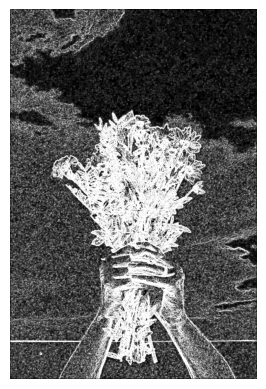

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

# Open and display the output PGM image
image = Image.open("outImage.jpg")
plt.imshow(image, cmap="gray")
plt.axis("off")  # Hide axes
plt.show()